In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


### Load Python Packages

In [2]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.base import clone
from sklearn import set_config
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer, quantile_transform

#statistics
from scipy.stats import randint, mode
from scipy.optimize import minimize

#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

#feature engineering
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV

#algorithms
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingRegressor

#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, make_scorer, RocCurveDisplay, confusion_matrix
from sklearn.metrics import roc_curve, matthews_corrcoef, cohen_kappa_score

# Optuna and visualization tools
import optuna
USE_OPTUNA = False
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

from matplotlib.colors import LinearSegmentedColormap

random_state = 42

SEED = 42
n_splits = 5

### First Look into Data : 
Check for missing values

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")
#original = pd.read_csv("/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv")

#original['Depression'] = original['Depression'].map({'Yes': 1, 'No': 0})
# train = pd.concat([train, original], ignore_index=True)
train_df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [4]:
train_df.isna().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

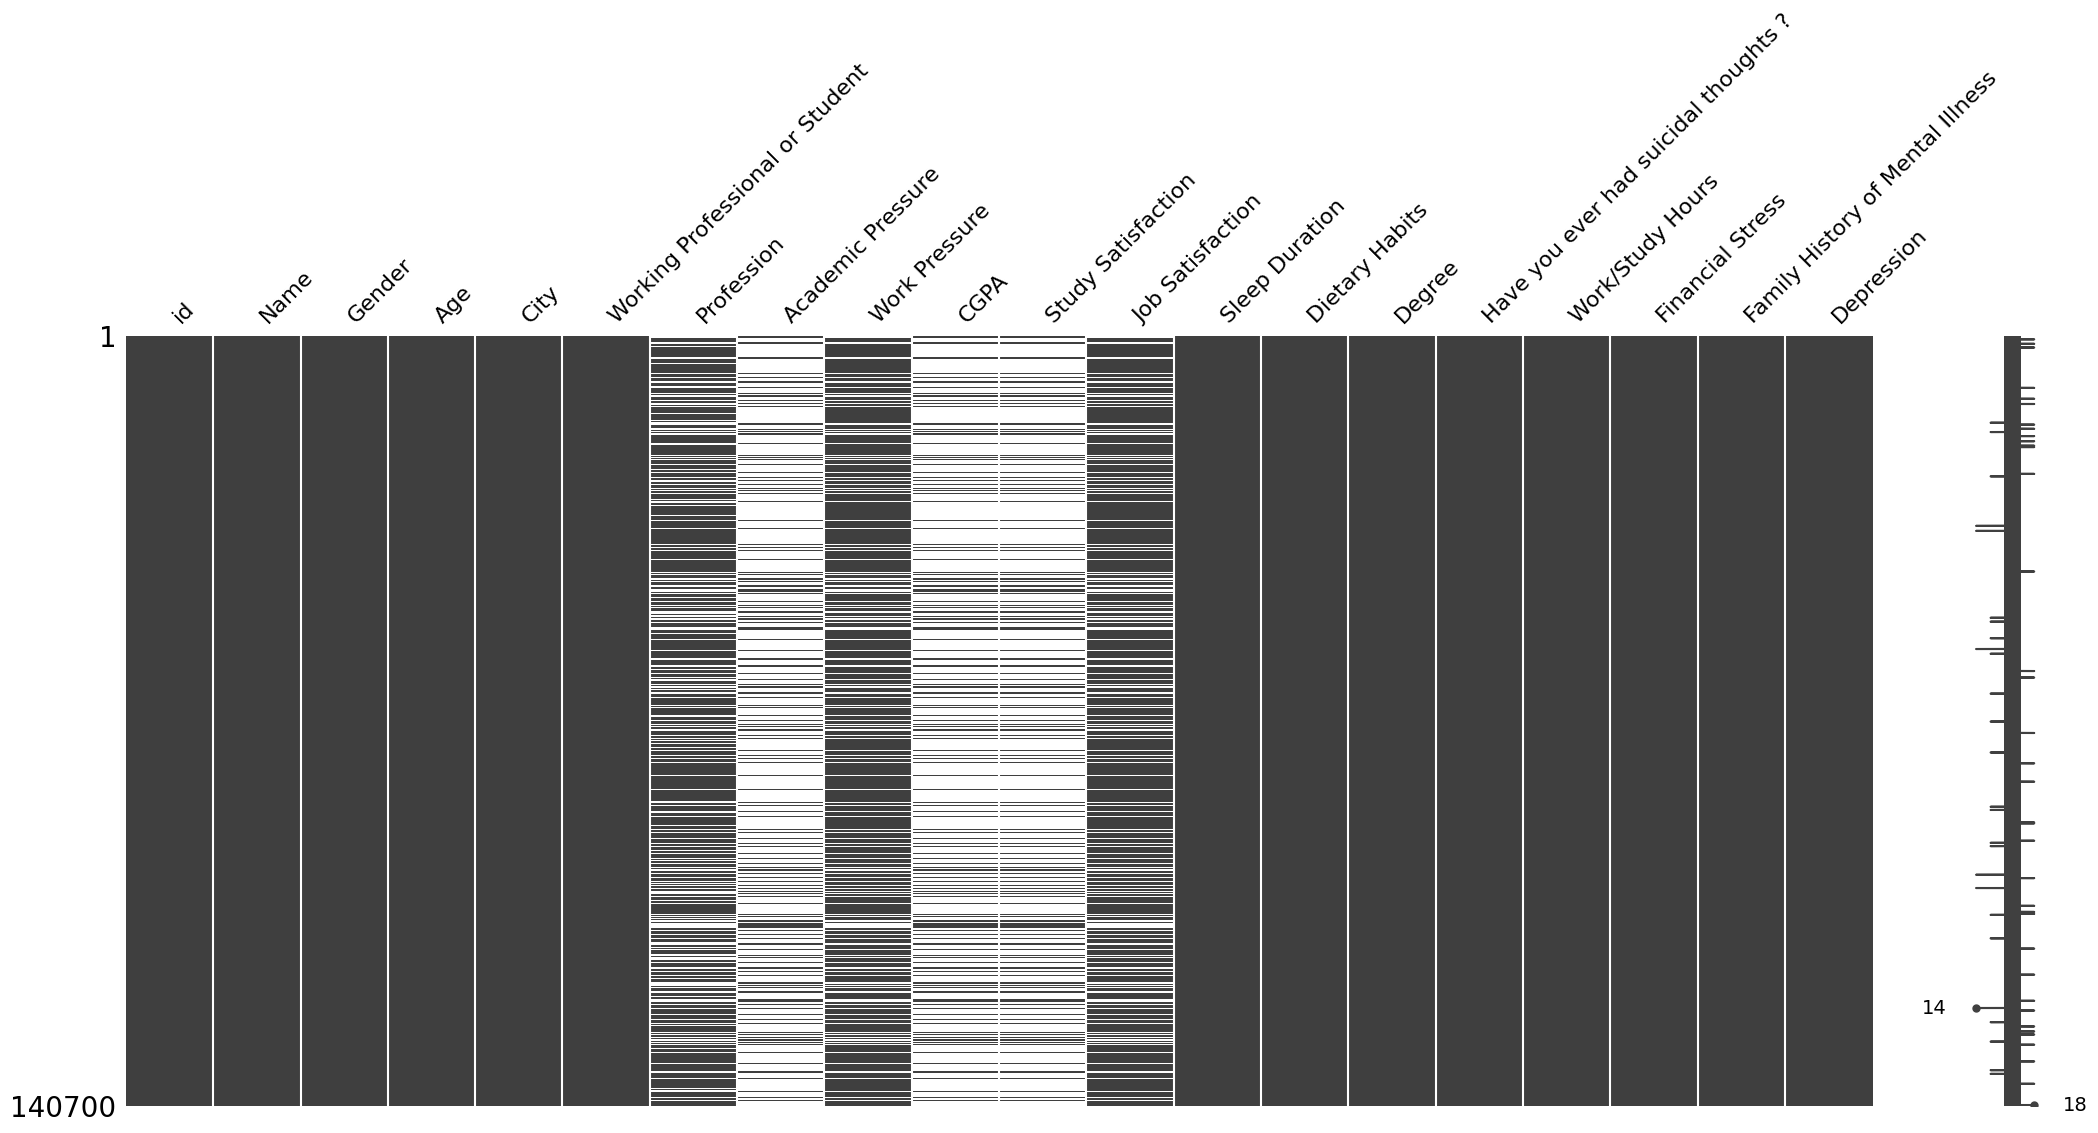

In [5]:
%matplotlib inline
msno.matrix(train_df)
plt.show()

In [6]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df)*100
missing.style.background_gradient('viridis')

,missing_count,missing_percent
Study Satisfaction,112803,80.172708
Academic Pressure,112803,80.172708
CGPA,112802,80.171997
Profession,36630,26.034115
Work Pressure,27918,19.842217
Job Satisfaction,27910,19.836532
Financial Stress,4,0.002843
Dietary Habits,4,0.002843
Degree,2,0.001421


### Descriptive statistics

In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,140700.0,70349.500000,40616.735775,0.00,35174.75,70349.50,105524.25,140699.0
Age,140700.0,40.388621,12.384099,18.00,29.00,42.00,51.00,60.0
Academic Pressure,27897.0,3.142273,1.380457,1.00,2.00,3.00,4.00,5.0
Work Pressure,112782.0,2.998998,1.405771,1.00,2.00,3.00,4.00,5.0
CGPA,27898.0,7.658636,1.464466,5.03,6.29,7.77,8.92,10.0
Study Satisfaction,27897.0,2.944940,1.360197,1.00,2.00,3.00,4.00,5.0
Job Satisfaction,112790.0,2.974404,1.416078,1.00,2.00,3.00,4.00,5.0
Work/Study Hours,140700.0,6.252679,3.853615,0.00,3.00,6.00,10.00,12.0
Financial Stress,140696.0,2.988983,1.413633,1.00,2.00,3.00,4.00,5.0
Depression,140700.0,0.181713,0.385609,0.00,0.00,0.00,0.00,1.0


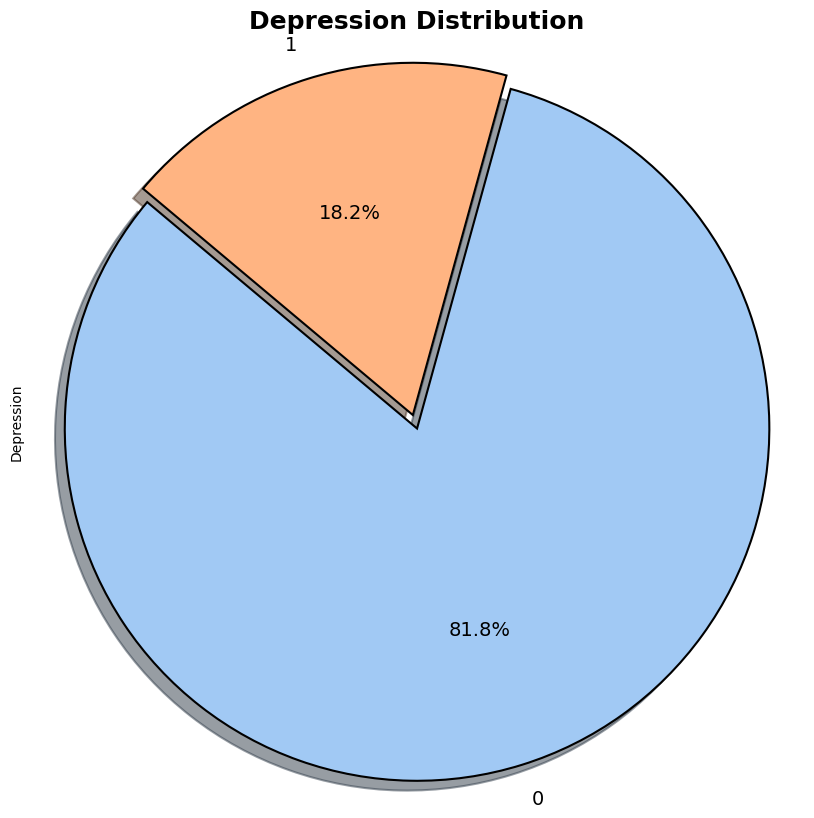

In [8]:
#Target frequency

plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.02 for _ in range(train_df['Depression'].nunique())]

# Plotting
train_df.groupby('Depression')['Depression'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Depression Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()


Since classes are imbalanced, accuracy is not the best way to evaluate the model performance. We can get 82% accuracy just by constantly predicting 0 on all samples.

### Grouping features for preprocessing purposes


In [9]:
train_df.nunique().sort_values()

Gender                                        2
Working Professional or Student               2
Have you ever had suicidal thoughts ?         2
Depression                                    2
Family History of Mental Illness              2
Job Satisfaction                              5
Study Satisfaction                            5
Academic Pressure                             5
Work Pressure                                 5
Financial Stress                              5
Work/Study Hours                             13
Dietary Habits                               23
Sleep Duration                               36
Age                                          43
Profession                                   64
City                                         98
Degree                                      115
CGPA                                        331
Name                                        422
id                                       140700
dtype: int64

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

### Feature Typess

### Exploratory Data Analysis

### Fixing Missing Data

In [11]:
train_df = train_df.fillna('None').astype('string')
test_df = test_df.fillna('None').astype('string')

target_col = 'Depression'

y = train_df[target_col]
X = train_df.drop([target_col], axis=1)

def update(df, threshold=10):
    
    corrected_category_features = ["Sleep Duration", "Dietary Habits", "Degree"]

    for col in corrected_category_features:
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < threshold, col] = 'None'
    
    df = df.fillna('None').astype('string')
        
    return df

In [12]:
train_df = update(train_df)
test_df = update(test_df)

### Model

I'll be using ROC-AUC and Accuracy to assess the model, actually focusing on ROC-AUC during training.

In [13]:
catboost_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.08114394459649094,
    'iterations': 1000,
    'depth': 6,
    'random_strength':0,
    'l2_leaf_reg': 0.7047064221215757,
    'task_type':'GPU',
    'random_seed':42,
    'verbose':False    
}

In [14]:
cv = StratifiedKFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X, y)
scores = []
test_preds = []
X_test_pool = Pool(test_df, cat_features=X.columns.values)
for i, (train_idx, val_idx) in enumerate(cv_splits):
    model = CatBoostClassifier(**catboost_params)
    X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]
    y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]
    X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X.columns.values)
    X_valid_pool = Pool(X_val_fold, y_val_fold, cat_features=X.columns.values)
    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=200)
    val_pred = model.predict(X_valid_pool)
    score = accuracy_score(y_val_fold, val_pred)
    scores.append(score)
    test_pred = model.predict_proba(X_test_pool)[:, 1]
    test_preds.append(test_pred)
    print(f'Fold {i + 1} accuracy_score: {score}')
print(f'Cross-validated accuracy_score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
print(f'Max accuracy_score score: {np.max(scores):.3f}')
print(f'Min accuracy_score score: {np.min(scores):.3f}')

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 accuracy_score: 0.9410803127221038


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 accuracy_score: 0.937775408670931


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 accuracy_score: 0.940227434257285


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 accuracy_score: 0.9402985074626866


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 accuracy_score: 0.9396588486140725
Cross-validated accuracy_score: 0.940 +/- 0.001
Max accuracy_score score: 0.941
Min accuracy_score score: 0.938


### Submission

In [15]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
sample_submission['Depression'] = np.round(np.mean(test_preds, axis=0))
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,id,Depression
0,140700,0.0
1,140701,0.0
2,140702,0.0
3,140703,1.0
4,140704,0.0
5,140705,0.0
6,140706,0.0
7,140707,0.0
8,140708,0.0
9,140709,1.0
